# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
using Libdl
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.2827126453578708  
 0.06463623983304956 
 0.4627146905652477  
 0.8358529878101912  
 0.3984667188692872  
 0.837492588126759   
 0.38054499375758355 
 0.9750196375642786  
 0.3446448314438204  
 0.7695023759529682  
 0.29586294269730495 
 0.7811955856158506  
 0.7964641283141283  
 ⋮                   
 0.5624435442635991  
 0.6570676328986034  
 0.0701414137967169  
 0.6112132374269506  
 0.7247392766528542  
 0.37438064086657663 
 0.07895754539168132 
 0.023359709183954802
 0.9197957607350353  
 0.5956601423819035  
 0.7229758038031526  
 0.0327275723579481  

In [2]:
sum(a)

4.9999443957538735e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

@time sum(a)

@time sum(a)

  0.008037 seconds (5 allocations: 176 bytes)
  0.007036 seconds (5 allocations: 176 bytes)
  0.008608 seconds (5 allocations: 176 bytes)


4.9999443957538735e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [ ]:
#Pkg.add("BenchmarkTools")

In [4]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [5]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

4.999944395753825e6

In [7]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [8]:
c_sum(a) - sum(a)  

-4.842877388000488e-8

In [ ]:
≈  # alias for the `isapprox` function

In [9]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [10]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.316 ms (0.00% GC)
  median time:      11.428 ms (0.00% GC)
  mean time:        12.122 ms (0.00% GC)
  maximum time:     21.005 ms (0.00% GC)
  --------------
  samples:          413
  evals/sample:     1

In [11]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.315909 msec


In [12]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 10.3159

In [17]:
using Plots
gr()

Plots.GRBackend()

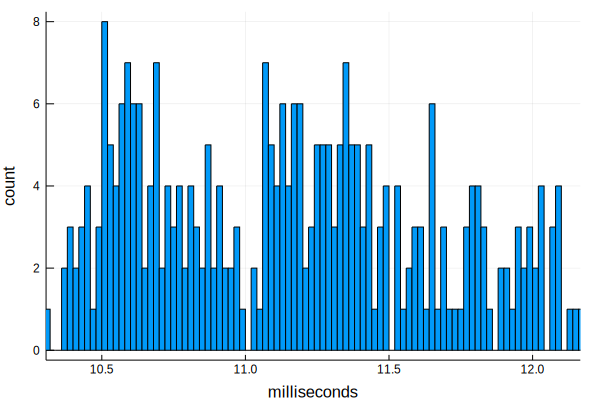

In [18]:
using Statistics
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [16]:
using PyCall

┌ Info: Recompiling stale cache file /home/ricardohe97/.julia/compiled/v1.0/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184


In [19]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [20]:
pysum(a)

4.999944395753825e6

In [21]:
pysum(a) ≈ sum(a)

true

In [22]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     787.462 ms (0.00% GC)
  median time:      794.243 ms (0.00% GC)
  mean time:        806.534 ms (0.00% GC)
  maximum time:     865.575 ms (0.00% GC)
  --------------
  samples:          7
  evals/sample:     1

In [23]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 10.3159
  "Python built-in" => 787.462

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [24]:
using Conda

In [25]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     7.046 ms (0.00% GC)
  median time:      7.130 ms (0.00% GC)
  mean time:        7.231 ms (0.00% GC)
  maximum time:     10.102 ms (0.00% GC)
  --------------
  samples:          691
  evals/sample:     1

In [26]:
numpy_sum(a)

4.999944395753877e6

In [27]:
numpy_sum(a) ≈ sum(a)

true

In [28]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 10.3159
  "Python numpy"    => 7.04558
  "Python built-in" => 787.462

# 4. Python, hand-written 

In [29]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fd89af75048>

In [30]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     916.090 ms (0.00% GC)
  median time:      972.487 ms (0.00% GC)
  mean time:        967.862 ms (0.00% GC)
  maximum time:     1.011 s (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [31]:
sum_py(a)

4.999944395753825e6

In [32]:
sum_py(a) ≈ sum(a)

true

In [33]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 10.3159
  "Python numpy"        => 7.04558
  "Python hand-written" => 916.09
  "Python built-in"     => 787.462

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [34]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

In [35]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.951 ms (0.00% GC)
  median time:      7.180 ms (0.00% GC)
  mean time:        7.354 ms (0.00% GC)
  maximum time:     11.734 ms (0.00% GC)
  --------------
  samples:          679
  evals/sample:     1

In [36]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 10.3159
  "Python numpy"        => 7.04558
  "Python hand-written" => 916.09
  "Python built-in"     => 787.462
  "Julia built-in"      => 6.95127

# 6. Julia (hand-written) 

In [37]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [38]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.186 ms (0.00% GC)
  median time:      10.819 ms (0.00% GC)
  mean time:        10.806 ms (0.00% GC)
  maximum time:     11.991 ms (0.00% GC)
  --------------
  samples:          463
  evals/sample:     1

In [39]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 10.3159
  "Python numpy"        => 7.04558
  "Julia hand-written"  => 10.1865
  "Python hand-written" => 916.09
  "Python built-in"     => 787.462
  "Julia built-in"      => 6.95127

# 7. Julia (hand-written w. simd) 

In [40]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [41]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.872 ms (0.00% GC)
  median time:      7.077 ms (0.00% GC)
  mean time:        7.238 ms (0.00% GC)
  maximum time:     10.071 ms (0.00% GC)
  --------------
  samples:          690
  evals/sample:     1

In [42]:
mysum_simd(a)

4.999944395753887e6

In [43]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "Julia hand-written simd" => 6.87214
  "C"                       => 10.3159
  "Python numpy"            => 7.04558
  "Julia hand-written"      => 10.1865
  "Python hand-written"     => 916.09
  "Python built-in"         => 787.462
  "Julia built-in"          => 6.95127

# Summary

In [45]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value), 6, "."))
end

Julia hand-written simd.....7.0
Julia built-in..............7.0
Python numpy................7.0
Julia hand-written.........10.0
C..........................10.0
Python built-in...........787.0
Python hand-written.......916.0
